# Resampling signals on the 2-sphere

## Setup

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics import ResampleS2
from torch_harmonics.quadrature import _precompute_latitudes

import matplotlib.pyplot as plt
from plotting import plot_sphere

let's start by downloading our Mars topography again.

In [2]:
nlat = 256
nlon = 2*nlat
grid = "equiangular"

xq, wq = _precompute_latitudes(nlat, grid=grid)

In [3]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze().float()

/home/bbonev/.zshenv:export:2: not valid in this context: :/usr/local/cuda-11.7/lib64
--2024-08-29 15:13:01--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K   169KB/s    in 0.3s    

2024-08-29 15:13:02 (169 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



let's plot it:

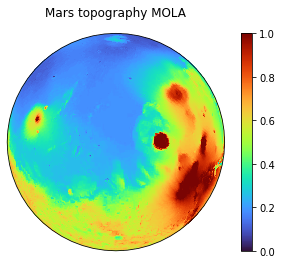

In [20]:
import matplotlib.pyplot as plt
from plotting import plot_sphere

plot_sphere(data, cmap="turbo", colorbar=True, title="Mars topography MOLA")
plt.show()

## Resampling

let us define down- and up-sampling layers:

In [26]:
scaling_factor = 0.25

downsample = ResampleS2(nlat, nlon, int(scaling_factor * nlat), int(scaling_factor * nlon), grid_in=grid, grid_out=grid)
upsample = ResampleS2(int(scaling_factor * nlat), int(scaling_factor * nlon), nlat, nlon, grid_in=grid, grid_out=grid)

In [27]:
data_down = downsample(data)
data_up = upsample(data_down)

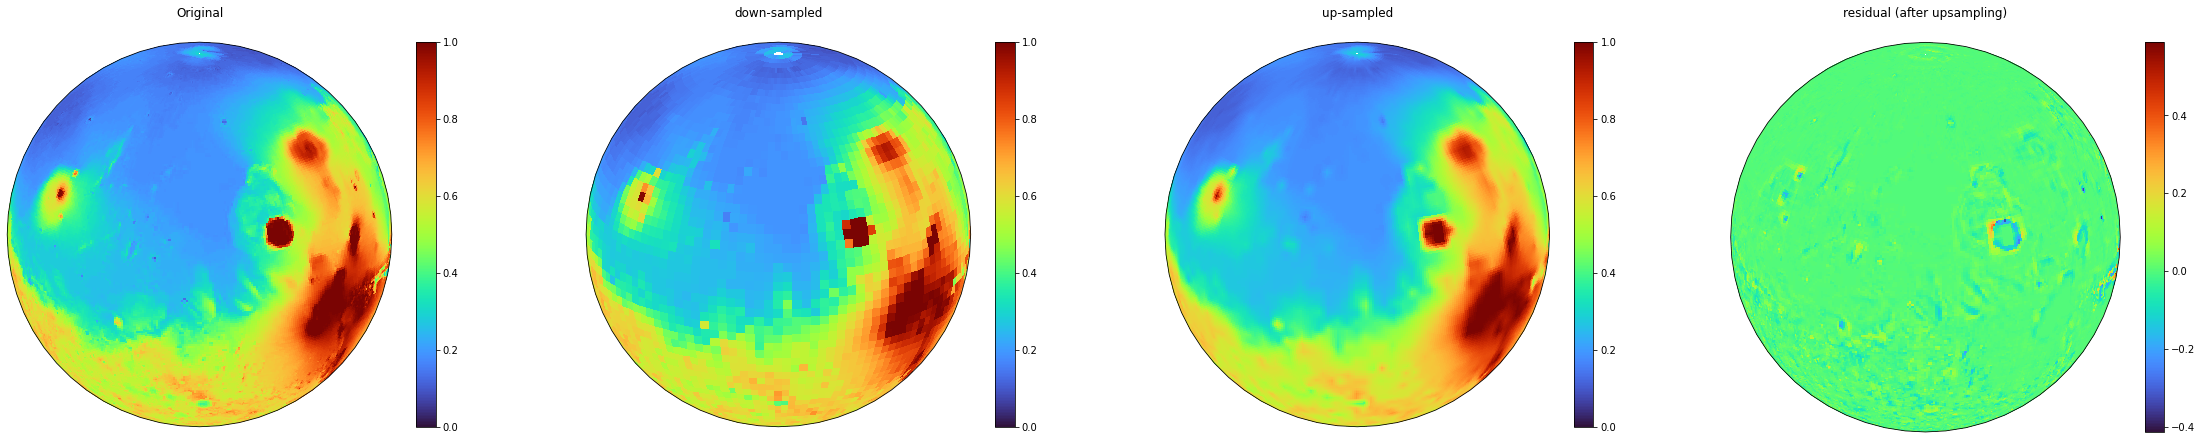

In [28]:
fig = plt.figure(layout='constrained', figsize=(32, 6))
subfigs = fig.subfigures(1, 4)

# spectral fitting
plot_sphere(data, fig=subfigs[0], cmap="turbo", colorbar=True, title="Original")
plot_sphere(data_down, fig=subfigs[1], cmap="turbo", colorbar=True, title="down-sampled")
plot_sphere(data_up, fig=subfigs[2], cmap="turbo", colorbar=True, title="up-sampled")
plot_sphere((data_up - data), fig=subfigs[3], cmap="turbo", colorbar=True, title="residual (after upsampling)")
plt.show()